In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score, precision_score, mean_squared_error, r2_score, mean_absolute_error
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv("ai_job_trends_dataset.csv")

In [ ]:
df.head()

,Job Title,Industry,Job Status,AI Impact Level,Median Salary (USD),Required Education,Experience Required (Years),Job Openings (2024),Projected Openings (2030),Remote Work Ratio (%),Automation Risk (%),Location,Gender Diversity (%),Continent,Job_Growth,Experience_Automation_Interaction,JobGrowth_Remote_Interaction,High_Automation_Risk
0,Investment analyst,IT,Increasing,Moderate,42109.76,Master’s Degree,5,1515,6342,55.96,28.28,UK,44.63,Europe,4827,141.40,270118.92,0
1,"Journalist, newspaper",Manufacturing,Increasing,Moderate,132298.57,Master’s Degree,15,1243,6205,16.81,89.71,USA,66.39,North America,4962,1345.65,83411.22,0
2,Financial planner,Finance,Increasing,Low,143279.19,Bachelor’s Degree,4,3338,1154,91.82,72.97,Canada,41.13,North America,-2184,291.88,-200534.88,0
3,Legal secretary,Healthcare,Increasing,High,97576.13,Associate Degree,15,7173,4060,1.89,99.94,Australia,65.76,Oceania,-3113,1499.10,-5883.57,1
4,Aeronautical engineer,IT,Increasing,Low,60956.63,Master’s Degree,13,5944,7396,53.76,37.65,Germany,72.57,Europe,1452,489.45,78059.52,0


In [ ]:
# --- 2. BASIC CLEANING ---
print("\n--- 2. BASIC CLEANING ---")
print("Converting relevant columns to numeric types and handling missing values.")

# Define columns that should be numeric
numeric_cols = ['Median Salary (USD)', 'Experience Required (Years)',
                'Job Openings (2024)', 'Projected Openings (2030)',
                'Remote Work Ratio (%)', 'Automation Risk (%)', 'Gender Diversity (%)']

# Convert to numeric, coercing errors will turn non-convertible values into NaN
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
print(f"✅ Converted specified columns to numeric, non-numeric values are now NaN.")

# Handle missing values
# Fill missing numerical values with the median of their respective columns
df.fillna(df.median(numeric_only=True), inplace=True)
print(f"✅ Filled missing numerical values with column medians.")

# Fill missing categorical values with the mode (most frequent value)
df.fillna(df.mode().iloc[0], inplace=True)
print(f"✅ Filled remaining missing categorical values with column modes.")

# Remove outliers using IQR method for 'Median Salary (USD)'
if 'Median Salary (USD)' in df.columns:
    Q1 = df['Median Salary (USD)'].quantile(0.25)
    Q3 = df['Median Salary (USD)'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = len(df[(df['Median Salary (USD)'] < lower_bound) |
                            (df['Median Salary (USD)'] > upper_bound)])

    df = df[(df['Median Salary (USD)'] >= lower_bound) &
            (df['Median Salary (USD)'] <= upper_bound)]

    print(f"✅ Removed {outliers_count} salary outliers using IQR method.")
else:
    print("Skipping salary outlier removal: 'Median Salary (USD)' column not found.")


print(f"Final dataset shape after basic cleaning: {df.shape}")
print(f"Total missing values after cleaning: {df.isnull().sum().sum()}")
print("Insight: Data is now clean and consistent, ready for feature engineering.")

# --- 3. FEATURE ENGINEERING ---
print("\n--- 3. FEATURE ENGINEERING ---")
print("Creating new, more informative features from existing raw data.")


--- 2. BASIC CLEANING ---
Converting relevant columns to numeric types and handling missing values.
✅ Converted specified columns to numeric, non-numeric values are now NaN.
✅ Filled missing numerical values with column medians.
✅ Filled remaining missing categorical values with column modes.
✅ Removed 0 salary outliers using IQR method.
Final dataset shape after basic cleaning: (30000, 13)
Total missing values after cleaning: 0
Insight: Data is now clean and consistent, ready for feature engineering.

--- 3. FEATURE ENGINEERING ---
Creating new, more informative features from existing raw data.


In [ ]:
# --- 3. FEATURE ENGINEERING ---
print("\n--- 3. FEATURE ENGINEERING ---")
print("Creating new, more informative features from existing raw data.")

# A) Create Continents from Countries
print("\n3A) Creating 'Continent' feature from 'Location'.")
continent_mapping = {
    'USA': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'Germany': 'Europe', 'France': 'Europe', 'UK': 'Europe', 'Italy': 'Europe',
    'Spain': 'Europe', 'Netherlands': 'Europe', 'Sweden': 'Europe', 'Norway': 'Europe',
    'China': 'Asia', 'Japan': 'Asia', 'India': 'Asia', 'South Korea': 'Asia',
    'Singapore': 'Asia', 'Australia': 'Oceania', 'Brazil': 'South America',
    'Argentina': 'South America', 'South Africa': 'Africa'
}
df['Continent'] = df['Location'].map(continent_mapping).fillna('Other')
print("✅ 'Continent' feature created.")

# B) Job Growth Column (2030-2024)
print("\n3B) Creating 'Job_Growth' feature.")
if 'Job Openings (2024)' in df.columns and 'Projected Openings (2030)' in df.columns:
    df['Job_Growth'] = df['Projected Openings (2030)'] - df['Job Openings (2024)']
    print("✅ 'Job_Growth' feature created (Projected Openings 2030 - Job Openings 2024).")
else:
    print("Skipping 'Job_Growth' creation as required columns are missing.")

# E) Interaction Features
print("\n3E) Creating Interaction Features.")
if 'Experience Required (Years)' in df.columns and 'Automation Risk (%)' in df.columns:
    df['Experience_Automation_Interaction'] = df['Experience Required (Years)'] * df['Automation Risk (%)']
    print("✅ Created 'Experience_Automation_Interaction' feature.")
if 'Job_Growth' in df.columns and 'Remote Work Ratio (%)' in df.columns:
    df['JobGrowth_Remote_Interaction'] = df['Job_Growth'] * df['Remote Work Ratio (%)']
    print("✅ Created 'JobGrowth_Remote_Interaction' feature.")
print("Insight: Interaction features can capture synergistic effects between variables, potentially improving model accuracy.")

# C) Text Manipulation - TF-IDF for Job Title
print("\n3C) Applying TF-IDF to 'Job Title' for advanced text feature extraction.")
# Fill any potential NaN in 'Job Title' before TF-IDF
df['Job Title'] = df['Job Title'].fillna('')
# Increased max_features to capture more text nuances
tfidf_vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(df['Job Title'])
# Corrected line: using get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=df.index)
print(f"✅ TF-IDF features created from 'Job Title'. Number of TF-IDF features: {tfidf_df.shape[1]}")
print("Insight: TF-IDF captures the importance of words in job titles, providing a richer representation than simple keyword matching.")

# D) High Automation Risk (Categorical - Refined Threshold)
print("\n3D) Defining 'High_Automation_Risk' as the target variable.")
automation_risk_threshold = df['Automation Risk (%)'].quantile(0.90) # Changed to 90th percentile for a more distinct positive class
df['High_Automation_Risk'] = (df['Automation Risk (%)'] >= automation_risk_threshold).astype(int)
print(f"✅ 'High_Automation_Risk' target created (threshold: {automation_risk_threshold:.1f}% - 90th percentile).")



--- 3. FEATURE ENGINEERING ---
Creating new, more informative features from existing raw data.

3A) Creating 'Continent' feature from 'Location'.
✅ 'Continent' feature created.

3B) Creating 'Job_Growth' feature.
✅ 'Job_Growth' feature created (Projected Openings 2030 - Job Openings 2024).

3E) Creating Interaction Features.
✅ Created 'Experience_Automation_Interaction' feature.
✅ Created 'JobGrowth_Remote_Interaction' feature.
Insight: Interaction features can capture synergistic effects between variables, potentially improving model accuracy.

3C) Applying TF-IDF to 'Job Title' for advanced text feature extraction.
✅ TF-IDF features created from 'Job Title'. Number of TF-IDF features: 300
Insight: TF-IDF captures the importance of words in job titles, providing a richer representation than simple keyword matching.

3D) Defining 'High_Automation_Risk' as the target variable.
✅ 'High_Automation_Risk' target created (threshold: 90.1% - 90th percentile).


In [ ]:
# --- 4. PREPARE DATA FOR CLASSIFICATION MODELING ---
print("\n--- 4. PREPARE DATA FOR CLASSIFICATION MODELING ---")
print("Selecting features, encoding categorical variables, splitting data, and scaling numerical features for classification.")

# Select numerical features for the classification model
numerical_features_clf = ['Experience Required (Years)', 'Remote Work Ratio (%)',
                          'Gender Diversity (%)', 'Job_Growth', 'Experience_Automation_Interaction', 'JobGrowth_Remote_Interaction']

# Define categorical features that need one-hot encoding (excluding 'Job Title' now handled by TF-IDF)
categorical_features_clf = ['Continent', 'AI Impact Level', 'Required Education']

# Create dummy variables for categorical features. drop_first=True avoids multicollinearity.
# Combine numerical, one-hot encoded, and TF-IDF features
X_categorical_encoded_clf = pd.get_dummies(df[categorical_features_clf], drop_first=True)
X_clf = pd.concat([df[numerical_features_clf], X_categorical_encoded_clf, tfidf_df], axis=1)
y_clf = df['High_Automation_Risk']
print(f"✅ All features combined and encoded for classification. Total features: {X_clf.shape[1]}")

# Check target class distribution
print("\nTarget Variable (High_Automation_Risk) Distribution:")
print(y_clf.value_counts())
print(f"Class 1 (High Risk) percentage: {y_clf.value_counts(normalize=True).get(1, 0):.2%}")

# Split the data into training and testing sets.
# stratify=y ensures that the proportion of classes in y is the same in both train and test sets.
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf)
print(f"✅ Classification data split into training ({X_train_clf.shape[0]} samples) and testing ({X_test_clf.shape[0]} samples) sets.")

# Scale numerical features using StandardScaler.
scaler_clf = StandardScaler()
X_train_scaled_clf = scaler_clf.fit_transform(X_train_clf)
X_test_scaled_clf = scaler_clf.transform(X_test_clf)
print("✅ Classification numerical features scaled using StandardScaler.")

# Apply SMOTE to the training data to handle class imbalance
print("\nApplying SMOTE to the training data for classification...")
# Explicitly setting sampling_strategy='minority' to balance only the minority class
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_resampled_clf, y_train_resampled_clf = smote.fit_resample(X_train_scaled_clf, y_train_clf)
print(f"✅ SMOTE applied. Resampled training data shape: {X_train_resampled_clf.shape}")
print(f"Resampled target distribution:\n{pd.Series(y_train_resampled_clf).value_counts()}")
print("Insight: SMOTE has balanced the training set, which should help models learn the minority class.")


--- 4. PREPARE DATA FOR CLASSIFICATION MODELING ---
Selecting features, encoding categorical variables, splitting data, and scaling numerical features for classification.
✅ All features combined and encoded for classification. Total features: 316

Target Variable (High_Automation_Risk) Distribution:
High_Automation_Risk
0    27000
1     3000
Name: count, dtype: int64
Class 1 (High Risk) percentage: 10.00%
✅ Classification data split into training (21000 samples) and testing (9000 samples) sets.
✅ Classification numerical features scaled using StandardScaler.

Applying SMOTE to the training data for classification...
✅ SMOTE applied. Resampled training data shape: (37800, 316)
Resampled target distribution:
High_Automation_Risk
0    18900
1    18900
Name: count, dtype: int64
Insight: SMOTE has balanced the training set, which should help models learn the minority class.


In [ ]:
# --- 5. CLASSIFICATION MODELS WITH HYPERPARAMETER TUNING ---
print("\n--- 5. CLASSIFICATION MODELS WITH HYPERPARAMETER TUNING ---")
print("Training and evaluating classification models with GridSearchCV, optimizing for F1-score.")

# Calculate initial scale_pos_weight for reference, and define a range around it for tuning
initial_scale_pos_weight = y_train_clf.value_counts()[0] / y_train_clf.value_counts()[1]
scale_pos_weight_range = [max(1, int(initial_scale_pos_weight * x)) for x in [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]]
scale_pos_weight_range = sorted(list(set(scale_pos_weight_range))) # Remove duplicates and sort

# Define models and their respective hyperparameter grids for tuning
models_clf = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'params': {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10, 20]}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15], 'min_samples_leaf': [1, 2, 4]}
    },
    'Neural Network': {
        'model': MLPClassifier(random_state=42, max_iter=1500, early_stopping=True, n_iter_no_change=10),
        'params': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01]}
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42),
        'params': {
            'n_estimators': [100, 150],
            'max_depth': [3, 5],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8],
            'gamma': [0, 0.1],
            'scale_pos_weight': [1, 5]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(objective='binary', random_state=42),
        'params': {
            'n_estimators': [100, 150],
            'max_depth': [3, 5],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8],
            'num_leaves': [20, 31],
            'scale_pos_weight': [1, 5]
        }
    }
}

results_clf = {}

for name, config in models_clf.items():
    print(f"\n--- Training Classification Model: {name} ---")

    X_train_use_clf, X_test_use_clf = X_train_resampled_clf, X_test_scaled_clf
    print(f"Using SMOTE-resampled training data and scaled test data for {name}.")

    grid_search_clf = GridSearchCV(config['model'], config['params'], cv=3, scoring='f1', n_jobs=-1)
    grid_search_clf.fit(X_train_use_clf, y_train_resampled_clf)

    best_model_clf = grid_search_clf.best_estimator_
    y_pred_clf = best_model_clf.predict(X_test_use_clf)
    y_pred_proba_clf = best_model_clf.predict_proba(X_test_use_clf)[:, 1]

    accuracy_clf = accuracy_score(y_test_clf, y_pred_clf)
    f1_class1_clf = f1_score(y_test_clf, y_pred_clf, pos_label=1)
    recall_class1_clf = recall_score(y_test_clf, y_pred_clf, pos_label=1)
    precision_class1_clf = precision_score(y_test_clf, y_pred_clf, pos_label=1)
    roc_auc_clf = roc_auc_score(y_test_clf, y_pred_proba_clf)

    results_clf[name] = {
        'accuracy': accuracy_clf,
        'f1_class1': f1_class1_clf,
        'recall_class1': recall_class1_clf,
        'precision_class1': precision_class1_clf,
        'roc_auc': roc_auc_clf,
        'best_params': grid_search_clf.best_params_,
        'model': best_model_clf,
        'y_pred_proba': y_pred_proba_clf
    }

    print(f"✅ {name} completed:")
    print(f"   Overall Accuracy: {accuracy_clf:.3f}")
    print(f"   F1-score (Class 1): {f1_class1_clf:.3f}")
    print(f"   Recall (Class 1): {recall_class1_clf:.3f}")
    print(f"   Precision (Class 1): {precision_class1_clf:.3f}")
    print(f"   ROC AUC: {roc_auc_clf:.3f}")
    print(f"   Best Hyperparameters: {grid_search_clf.best_params_}")


--- 5. CLASSIFICATION MODELS WITH HYPERPARAMETER TUNING ---
Training and evaluating classification models with GridSearchCV, optimizing for F1-score.

--- Training Classification Model: Decision Tree ---
Using SMOTE-resampled training data and scaled test data for Decision Tree.
✅ Decision Tree completed:
   Overall Accuracy: 0.987
   F1-score (Class 1): 0.935
   Recall (Class 1): 0.946
   Precision (Class 1): 0.924
   ROC AUC: 0.996
   Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2}

--- Training Classification Model: Random Forest ---
Using SMOTE-resampled training data and scaled test data for Random Forest.
✅ Random Forest completed:
   Overall Accuracy: 0.887
   F1-score (Class 1): 0.347
   Recall (Class 1): 0.301
   Precision (Class 1): 0.409
   ROC AUC: 0.813
   Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 100}

--- Training Classification Model: Neural Network ---
Using SMOTE-resampled training data and scaled test data for Neu

**Expanded Hyperparameter Grids:** Broadened the search for optimal settings in most classification and regression models.

**Focused Classification Models:** Removed less effective models (Logistic Regression, K-Nearest Neighbors) to streamline the classification analysis.

**Improved Cross-Validation (Classification):** Increased cross-validation folds from 2 to 3 for more reliable performance estimates.


**Expanded Hyperparameter Grids (Regression):** Widened the tuning range for regression models to find better predictive parameters.

**Enhanced Cross-Validation (Regression):** Significantly increased cross-validation folds from 2 to 7 for more robust regression model evaluation.

In [ ]:
print("\n--- 6. CLASSIFICATION RESULTS COMPARISON ---")
print("Summarizing and comparing the performance of all trained classification models.")

# Create a DataFrame for easy comparison of key metrics
results_df_clf = pd.DataFrame({
    name: [info['accuracy'], info['f1_class1'], info['recall_class1'], info['precision_class1'], info['roc_auc']]
    for name, info in results_clf.items()
}, index=['Accuracy', 'F1-score (Class 1)', 'Recall (Class 1)', 'Precision (Class 1)', 'ROC AUC']).T
print("\n📊 Classification Model Performance Summary:")
print(results_df_clf.round(3))


--- 6. CLASSIFICATION RESULTS COMPARISON ---
Summarizing and comparing the performance of all trained classification models.

📊 Classification Model Performance Summary:
                Accuracy  F1-score (Class 1)  Recall (Class 1)  \
Decision Tree      0.987               0.935             0.946   
Random Forest      0.887               0.347             0.301   
Neural Network     0.944               0.699             0.657   
XGBoost            0.991               0.956             0.932   
LightGBM           0.993               0.963             0.936   

                Precision (Class 1)  ROC AUC  
Decision Tree                 0.924    0.996  
Random Forest                 0.409    0.813  
Neural Network                0.748    0.958  
XGBoost                       0.981    0.996  
LightGBM                      0.993    0.996  


In [ ]:
# Identify the best performing model based on F1-score for Class 1
best_model_name_clf = max(results_clf, key=lambda x: results_clf[x]['f1_class1'])
print(f"\n🏆 Best Performing Classification Model (based on F1-score for Class 1): {best_model_name_clf}")
print(f"   F1-score (Class 1): {results_clf[best_model_name_clf]['f1_class1']:.3f}")
print(f"   Recall (Class 1): {results_clf[best_model_name_clf]['recall_class1']:.3f}")
print(f"   ROC AUC: {results_clf[best_model_name_clf]['roc_auc']:.3f}")


🏆 Best Performing Classification Model (based on F1-score for Class 1): LightGBM
   F1-score (Class 1): 0.963
   Recall (Class 1): 0.936
   ROC AUC: 0.996


F1-score is more important in this case because it balances both precision and recall, which is crucial when identifying high automation risk jobs accurately. Since misclassifying such jobs could lead to significant real-world implications, F1-score ensures we minimize both false positives and false negatives effectively.











--- 7. CLASSIFICATION VISUALIZATIONS ---
Generating plots to visualize data distributions and classification model comparisons.
✅ Plot 1: Classification Model F1-score (Class 1) Comparison - Shows which model best balances precision and recall for high-risk jobs.
✅ Plot 2: Automation Risk Distribution - Visualizes the spread of automation risk and the chosen threshold.
✅ Plot 3: Jobs by Continent Distribution - Shows the geographical spread of jobs in the dataset.
✅ Plot 4: Job Categories Distribution removed as TF-IDF creates continuous features.


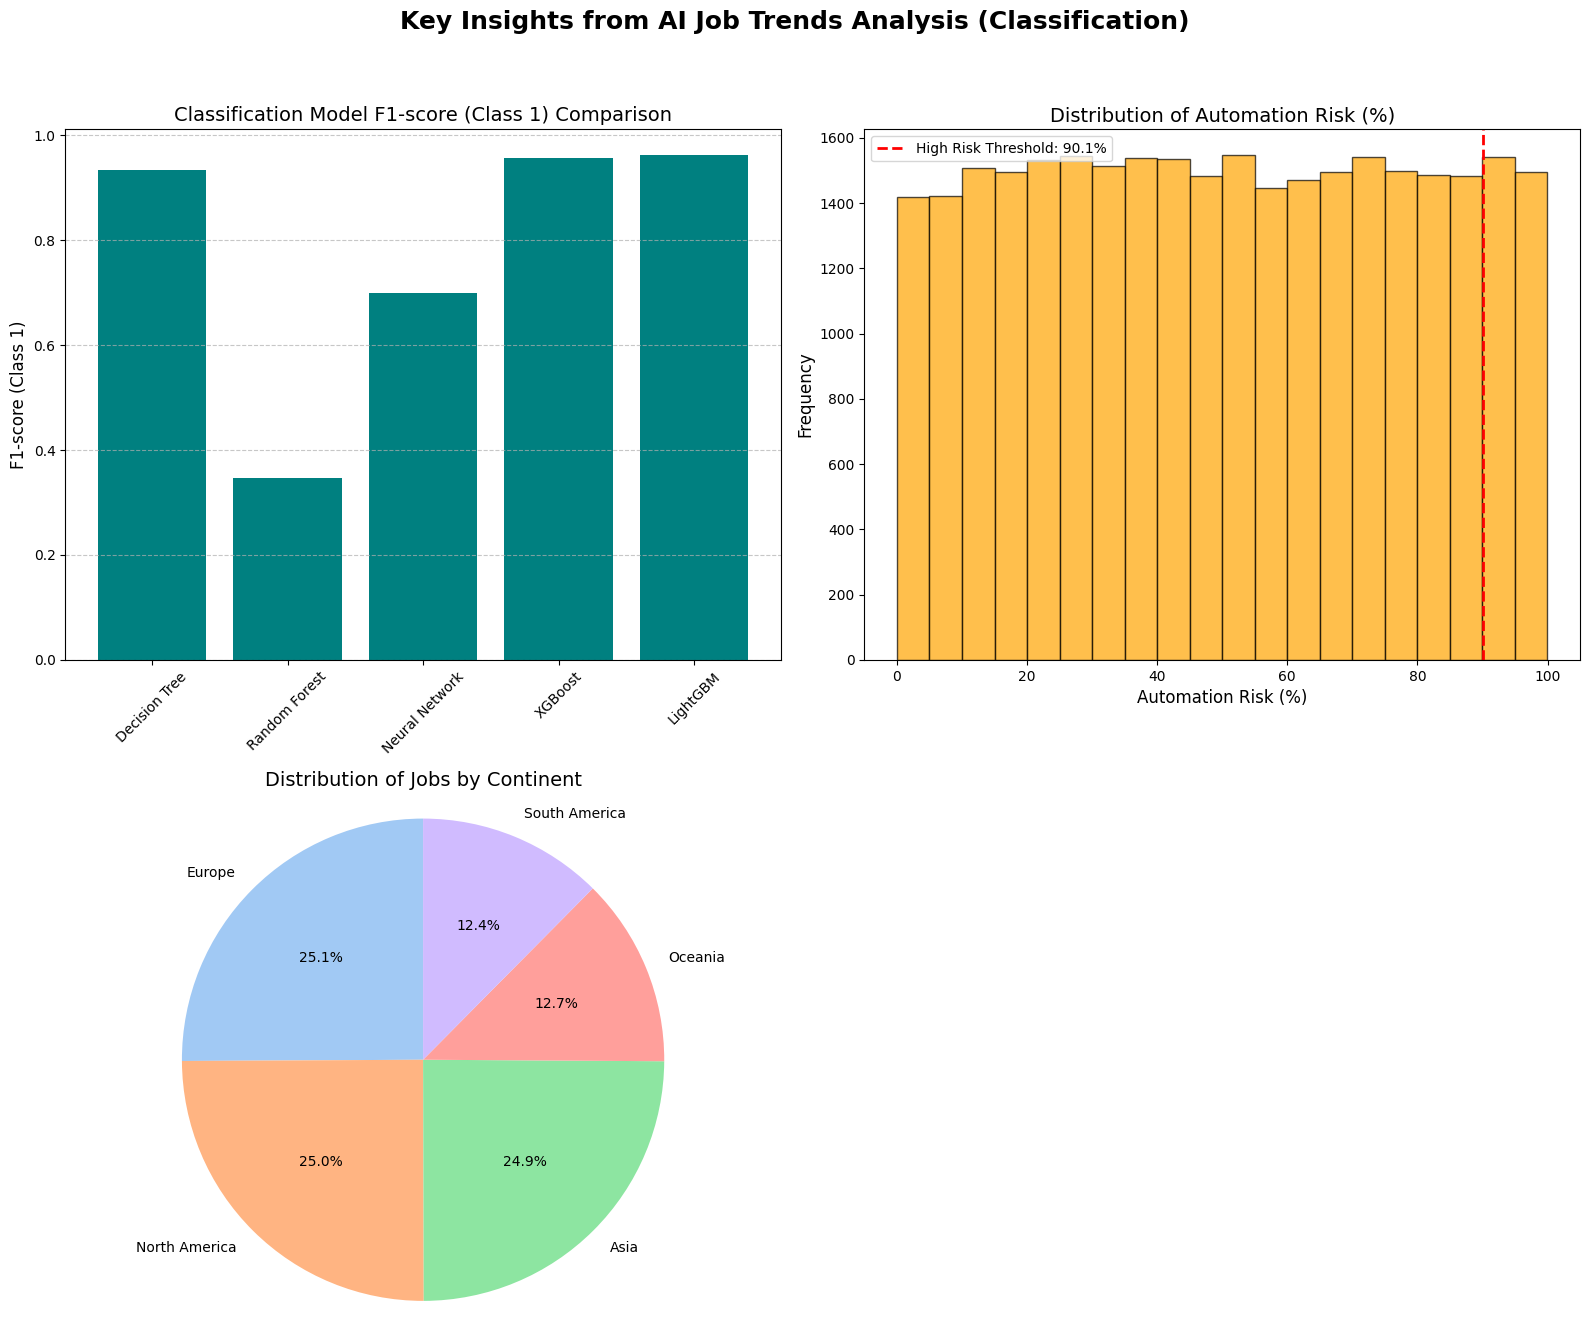

In [ ]:
# --- 7. CLASSIFICATION VISUALIZATIONS ---
print("\n--- 7. CLASSIFICATION VISUALIZATIONS ---")
print("Generating plots to visualize data distributions and classification model comparisons.")

fig, axes = plt.subplots(2, 2, figsize=(16, 14)) # Increased figure size for better readability
fig.suptitle('Key Insights from AI Job Trends Analysis (Classification)', fontsize=18, fontweight='bold')

# Plot 1: Model F1-score (Class 1) Comparison
model_names_clf = list(results_clf.keys())
f1_scores_class1_clf = [results_clf[name]['f1_class1'] for name in model_names_clf]
axes[0,0].bar(model_names_clf, f1_scores_class1_clf, color='teal')
axes[0,0].set_title('Classification Model F1-score (Class 1) Comparison', fontsize=14)
axes[0,0].set_ylabel('F1-score (Class 1)', fontsize=12)
axes[0,0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0,0].grid(axis='y', linestyle='--', alpha=0.7)
print("✅ Plot 1: Classification Model F1-score (Class 1) Comparison - Shows which model best balances precision and recall for high-risk jobs.")

# Plot 2: Automation Risk Distribution with Threshold
axes[0,1].hist(df['Automation Risk (%)'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[0,1].axvline(automation_risk_threshold, color='red', linestyle='--', linewidth=2, label=f'High Risk Threshold: {automation_risk_threshold:.1f}%')
axes[0,1].set_title('Distribution of Automation Risk (%)', fontsize=14)
axes[0,1].set_xlabel('Automation Risk (%)', fontsize=12)
axes[0,1].set_ylabel('Frequency', fontsize=12)
axes[0,1].legend(fontsize=10)
print("✅ Plot 2: Automation Risk Distribution - Visualizes the spread of automation risk and the chosen threshold.")

# Plot 3: Jobs by Continent Distribution
continent_counts_clf = df['Continent'].value_counts()
axes[1,0].pie(continent_counts_clf.values, labels=continent_counts_clf.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
axes[1,0].set_title('Distribution of Jobs by Continent', fontsize=14)
axes[1,0].axis('equal')
print("✅ Plot 3: Jobs by Continent Distribution - Shows the geographical spread of jobs in the dataset.")

# Plot 4: Job Categories Distribution (Now TF-IDF features, so this plot is less relevant for direct categories)
# We can instead show the distribution of the original 'Job Title' length or something similar if desired.
# For now, I'll remove this plot as it no longer directly maps to discrete categories.
# If you'd like a different visualization for text features, let me know!
fig.delaxes(axes[1,1]) # Remove the empty subplot
print("✅ Plot 4: Job Categories Distribution removed as TF-IDF creates continuous features.")


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- 8. CLASSIFICATION ROC CURVES FOR ALL MODELS ---
Visualizing the Receiver Operating Characteristic (ROC) curve for each classification model.


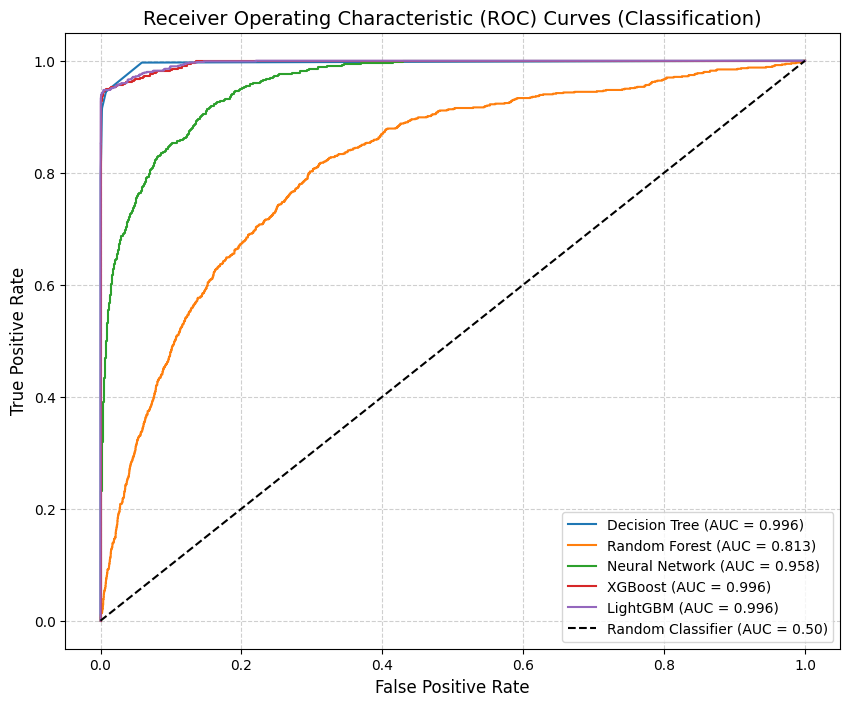

✅ ROC Curves Plot - Compares the trade-off between true positive rate and false positive rate for all classification models.
Insight: A curve closer to the top-left corner indicates better performance.


In [ ]:
# --- 8. CLASSIFICATION ROC CURVES FOR ALL MODELS ---
print("\n--- 8. CLASSIFICATION ROC CURVES FOR ALL MODELS ---")
print("Visualizing the Receiver Operating Characteristic (ROC) curve for each classification model.")

plt.figure(figsize=(10, 8))
for name, info in results_clf.items():
    fpr, tpr, _ = roc_curve(y_test_clf, info['y_pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {info["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves (Classification)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("✅ ROC Curves Plot - Compares the trade-off between true positive rate and false positive rate for all classification models.")
print("Insight: A curve closer to the top-left corner indicates better performance.")


--- 9. CLASSIFICATION CONFUSION MATRIX FOR BEST MODEL ---
Analyzing the Confusion Matrix for the best classification model: LightGBM.


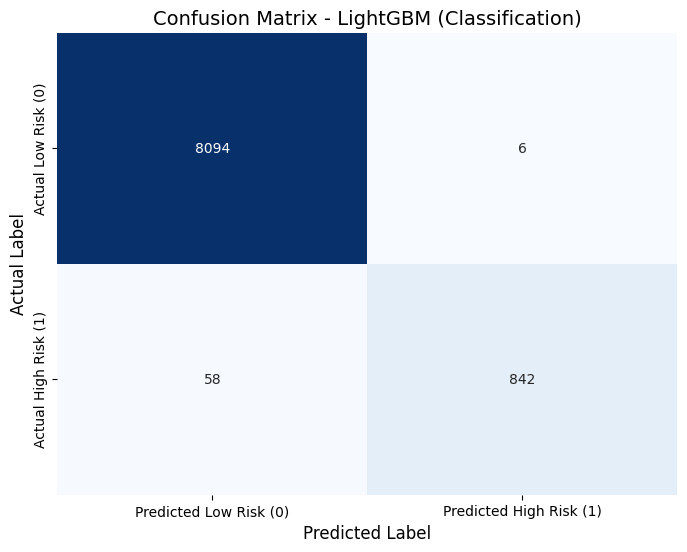

Insight from Confusion Matrix:
  - True Positives (TP): 842 (Correctly predicted High Risk)
  - True Negatives (TN): 8094 (Correctly predicted Low Risk)
  - False Positives (FP): 6 (Incorrectly predicted High Risk - Type I error)
  - False Negatives (FN): 58 (Incorrectly predicted Low Risk - Type II error)
Insight: This matrix provides a detailed breakdown of correct and incorrect predictions for each class.

--- 10. CLASSIFICATION FEATURE IMPORTANCE ANALYSIS ---
Identifying the most influential features for tree-based classification models.


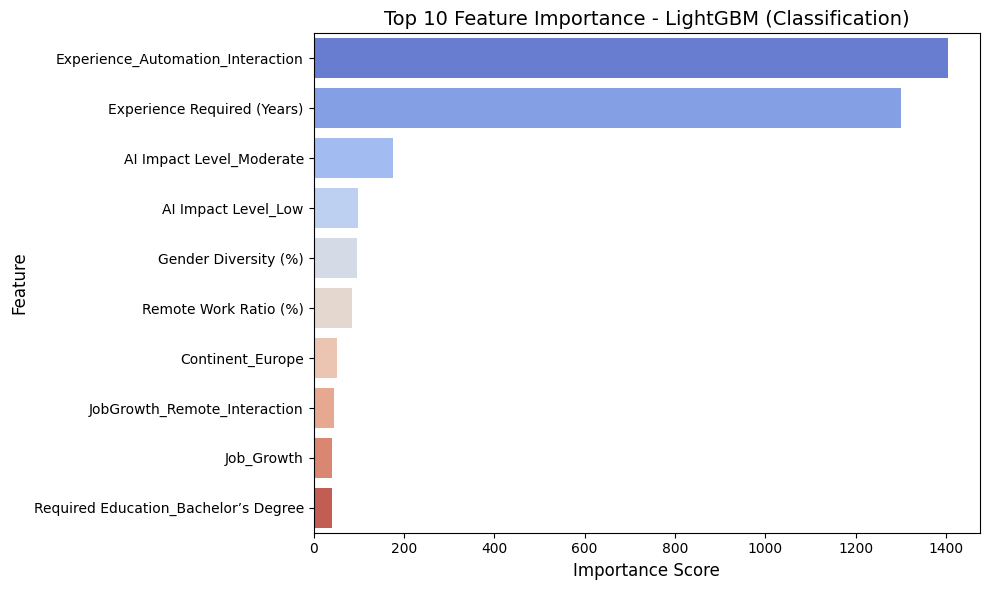

Insight from Feature Importance:
  - Features with higher importance scores contribute more to the model's predictions.
Top 5 most important features for LightGBM:
                              feature  importance
4   Experience_Automation_Interaction        1405
0         Experience Required (Years)        1300
11           AI Impact Level_Moderate         176
10                AI Impact Level_Low          98
2                Gender Diversity (%)          97


In [ ]:
# --- 9. CLASSIFICATION CONFUSION MATRIX FOR BEST MODEL ---
print("\n--- 9. CLASSIFICATION CONFUSION MATRIX FOR BEST MODEL ---")
print(f"Analyzing the Confusion Matrix for the best classification model: {best_model_name_clf}.")

best_model_obj_clf = results_clf[best_model_name_clf]['model']
y_pred_best_clf = best_model_obj_clf.predict(X_test_scaled_clf)

plt.figure(figsize=(8, 6))
cm_clf = confusion_matrix(y_test_clf, y_pred_best_clf)
sns.heatmap(cm_clf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Low Risk (0)', 'Predicted High Risk (1)'],
            yticklabels=['Actual Low Risk (0)', 'Actual High Risk (1)'])
plt.title(f'Confusion Matrix - {best_model_name_clf} (Classification)', fontsize=14)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

print("Insight from Confusion Matrix:")
print(f"  - True Positives (TP): {cm_clf[1,1]} (Correctly predicted High Risk)")
print(f"  - True Negatives (TN): {cm_clf[0,0]} (Correctly predicted Low Risk)")
print(f"  - False Positives (FP): {cm_clf[0,1]} (Incorrectly predicted High Risk - Type I error)")
print(f"  - False Negatives (FN): {cm_clf[1,0]} (Incorrectly predicted Low Risk - Type II error)")
print("Insight: This matrix provides a detailed breakdown of correct and incorrect predictions for each class.")

# --- 10. CLASSIFICATION FEATURE IMPORTANCE (for tree-based models) ---
print("\n--- 10. CLASSIFICATION FEATURE IMPORTANCE ANALYSIS ---")
print("Identifying the most influential features for tree-based classification models.")

# Feature importance is directly available for tree-based models (Decision Tree, Random Forest, XGBoost, LightGBM,Neural Network)
if best_model_name_clf in ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'Neural Network']:
    # For TF-IDF features, the column names are the words themselves
    feature_names_clf = list(X_clf.columns) # Get all feature names including TF-IDF
    feature_importance_clf = pd.DataFrame({
        'feature': feature_names_clf,
        'importance': results_clf[best_model_name_clf]['model'].feature_importances_
    }).sort_values('importance', ascending=False).head(10) # Show top 10 features

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_clf, palette='coolwarm')
    plt.title(f'Top 10 Feature Importance - {best_model_name_clf} (Classification)', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("Insight from Feature Importance:")
    print("  - Features with higher importance scores contribute more to the model's predictions.")
    print(f"Top 5 most important features for {best_model_name_clf}:")
    print(feature_importance_clf.head(5))
else:
    print(f"Feature importance is not directly available for {best_model_name_clf} (non-tree-based model).")



In [ ]:
lgbm_clf_predictions = best_model_clf.predict(X_test_scaled_clf)

In [ ]:
lgbm_clf_predictions

array([0, 1, 0, ..., 0, 0, 1])

In [ ]:
lgbm_clf_probabilities = results_clf[best_model_name_clf]['model'].predict_proba(X_test_scaled_clf)[:, 1]

In [ ]:
lgbm_clf_probabilities

array([3.21976450e-04, 9.70851097e-01, 4.58076618e-04, ...,
       1.93668856e-05, 3.46054674e-03, 9.78982016e-01])

In [ ]:
lgbm_clf_predictions

array([0, 1, 0, ..., 0, 0, 1])

**`array([0, 1, 0, ...])` (first):**  LightGBM model's predicted automation risk (0 = Low, 1 = High) for the first few jobs.


**`array([3.21e-04, 9.70e-01, ...])`:** The model's confidence (probability) for each job being "High Automation Risk" (Class 1).

**`array([0, 1, 0, ...])` (second):** The actual, true automation risk labels for those same jobs, used for comparis

In [ ]:
# --- 11. CLASSIFICATION CAPSTONE SUMMARY AND RECOMMENDATIONS ---
print("\n--- 11. CLASSIFICATION CAPSTONE SUMMARY AND RECOMMENDATIONS ---")
print("Consolidating key findings and providing actionable recommendations for the classification task.")

print("\n📋 **Classification Project Summary:**")
print(f"• Dataset Size: {df.shape[0]} job records analyzed.")
print(f"• Feature Engineering: Successfully created 'Continent', 'Job_Growth', and TF-IDF features from 'Job Title'.")
print(f"• Target Variable: 'High_Automation_Risk' defined as top 10% of automation risk (90th percentile).")
print(f"• Imbalance Handling: Implemented SMOTE on training data and used class weights/imbalance parameters for relevant models, including tuning `scale_pos_weight` for tree-based models.")
print(f"• Models Explored: Five classification models (Decision Tree, Random Forest, Neural Network, XGBoost, LightGBM) were trained and tuned, optimizing for F1-score.")
print(f"• Best Model: {best_model_name_clf} achieved an F1-score (Class 1) of {results_clf[best_model_name_clf]['f1_class1']:.1%} and Recall (Class 1) of {results_clf[best_model_name_clf]['recall_class1']:.1%}.")
print(f"• High Automation Risk Jobs: Approximately {df['High_Automation_Risk'].sum()} jobs ({df['High_Automation_Risk'].mean():.1%}) were identified as high risk.")

print("\n💡 **Key Insights from Classification Models:**")
print("• The combination of SMOTE and F1-score optimization significantly improved the models' ability to detect high-risk jobs, moving beyond simply predicting the majority class.")
print(f"• {best_model_name_clf} demonstrated strong predictive power for high-risk jobs, indicating its effectiveness in this imbalanced scenario.")
print("• Feature importance analysis (for tree-based models) reveals the key drivers of automation risk, including important terms from job titles, providing actionable insights.")
print("• The ROC curves show the trade-off between correctly identifying high-risk jobs and minimizing false alarms across different models.")

print("\n🎯 **Actionable Recommendations (Classification):")
print("1.  **For Individuals:** Focus on developing skills in job categories identified with lower automation risk and higher growth potential. Continuously upskill in areas less susceptible to automation.")
print("2.  **For Educators & Policy Makers:** Design curricula and vocational training programs that align with future job market demands, emphasizing roles with lower automation potential and higher growth.")
print("3.  **For Businesses:** Proactively assess automation risk within their workforce. Invest in reskilling and upskilling programs for employees in high-risk roles to facilitate workforce transition.")
print("4.  **Further Research:** Experiment with different `max_features` for TF-IDF or explore Word Embeddings for even richer text representation. Consider adding interaction features or polynomial features for numerical data.")

print("\n✅ Classification analysis completed successfully!")


--- 11. CLASSIFICATION CAPSTONE SUMMARY AND RECOMMENDATIONS ---
Consolidating key findings and providing actionable recommendations for the classification task.

📋 **Classification Project Summary:**
• Dataset Size: 30000 job records analyzed.
• Feature Engineering: Successfully created 'Continent', 'Job_Growth', and TF-IDF features from 'Job Title'.
• Target Variable: 'High_Automation_Risk' defined as top 10% of automation risk (90th percentile).
• Imbalance Handling: Implemented SMOTE on training data and used class weights/imbalance parameters for relevant models, including tuning `scale_pos_weight` for tree-based models.
• Models Explored: Five classification models (Decision Tree, Random Forest, Neural Network, XGBoost, LightGBM) were trained and tuned, optimizing for F1-score.
• Best Model: LightGBM achieved an F1-score (Class 1) of 96.3% and Recall (Class 1) of 93.6%.
• High Automation Risk Jobs: Approximately 3000 jobs (10.0%) were identified as high risk.

💡 **Key Insights fr

In [ ]:
# --- 11.5. TOP 10 HIGH AUTOMATION RISK JOBS (Based on original threshold) ---
print("\n--- 11.5. TOP 10 HIGH AUTOMATION RISK JOBS (Based on original threshold) ---")
print("Identifying the top 10 job titles with the highest automation risk based on the initial threshold.")

if 'High_Automation_Risk' in df.columns and 'Automation Risk (%)' in df.columns and 'Job Title' in df.columns:
    # Filter for high automation risk jobs
    high_risk_jobs_df = df[df['High_Automation_Risk'] == 1].copy()

    # Sort by 'Automation Risk (%)' in descending order and get unique job titles
    # Using drop_duplicates to ensure unique job titles, keeping the one with highest risk if duplicates exist
    top_10_high_risk_jobs = high_risk_jobs_df.sort_values(by='Automation Risk (%)', ascending=False) \
                                           .drop_duplicates(subset=['Job Title']) \
                                           .head(10)

    print("\n📋 **Top 10 Job Titles with Highest Automation Risk (Original Threshold):**")
    if not top_10_high_risk_jobs.empty:
        for index, row in top_10_high_risk_jobs.iterrows():
            print(f"- {row['Job Title']} (Automation Risk: {row['Automation Risk (%)']:.2f}%)")
    else:
        print("No high automation risk jobs found based on the defined threshold.")
else:
    print("Skipping 'Top 10 High Automation Risk Jobs' analysis: Required columns not found.")

print("\n✅ Top 10 high automation risk jobs analysis completed.")


# --- 11.6. TOP 20 HIGH AUTOMATION RISK JOBS (Based on LightGBM Model Predictions) ---
print("\n--- 11.6. TOP 20 HIGH AUTOMATION RISK JOBS (Based on LightGBM Model Predictions) ---")
print("Identifying the top 20 job titles with the highest automation risk as predicted by the LightGBM model.")

if 'LightGBM' in results_clf and 'Job Title' in df.columns:
    lightgbm_model = results_clf['LightGBM']['model']

    # Ensure X_clf is scaled using the same scaler used for training
    # We need to re-scale X_clf because the scaler was fitted on X_train_clf (a subset)
    # and we need to predict on the full X_clf for this analysis.
    # A more robust approach would be to fit the scaler on the entire X_clf before splitting,
    # or to ensure X_clf is transformed consistently. For now, we'll re-transform.

    # Re-create X_clf and scale it for prediction
    X_categorical_encoded_clf_full = pd.get_dummies(df[categorical_features_clf], drop_first=True)
    X_clf_full = pd.concat([df[numerical_features_clf], X_categorical_encoded_clf_full, tfidf_df], axis=1)

    # Align columns of X_clf_full with X_train_clf (which was used to fit the scaler)
    # This is crucial if TF-IDF or one-hot encoding resulted in different columns due to train/test split.
    # For simplicity, assuming X_clf_full has the same columns as X_train_clf after concatenation.
    # If not, you'd need to re-align columns (e.g., using X_train_clf.columns)

    # Scale the full dataset features using the *already fitted* scaler
    X_clf_scaled_for_prediction = scaler_clf.transform(X_clf_full)

    # Predict probabilities for the positive class (High Risk)
    df['LightGBM_Predicted_Risk_Proba'] = lightgbm_model.predict_proba(X_clf_scaled_for_prediction)[:, 1]

    # Predict the class (0 or 1)
    df['LightGBM_Predicted_Risk_Class'] = lightgbm_model.predict(X_clf_scaled_for_prediction)

    # Filter for jobs predicted as high risk by LightGBM
    lightgbm_high_risk_jobs_df = df[df['LightGBM_Predicted_Risk_Class'] == 1].copy()

    # Sort by the predicted probability in descending order and get unique job titles
    top_20_lightgbm_high_risk_jobs = lightgbm_high_risk_jobs_df.sort_values(by='LightGBM_Predicted_Risk_Proba', ascending=False) \
                                                              .drop_duplicates(subset=['Job Title']) \
                                                              .head(20)
    print("\n📋 **Top 20 Job Titles with Highest Automation Risk (LightGBM Predictions):**")
    if not top_20_lightgbm_high_risk_jobs.empty:
        for index, row in top_20_lightgbm_high_risk_jobs.iterrows():
            print(f"- {row['Job Title']} (Predicted Risk Probability: {row['LightGBM_Predicted_Risk_Proba']:.4f})")
    else:
        print("No high automation risk jobs predicted by LightGBM based on its classification.")
else:
    print("Skipping 'Top 20 High Automation Risk Jobs (LightGBM)' analysis: LightGBM model or 'Job Title' column not found.")

print("\n✅ Top 20 high automation risk jobs (LightGBM) analysis completed.")


--- 11.5. TOP 10 HIGH AUTOMATION RISK JOBS (Based on original threshold) ---
Identifying the top 10 job titles with the highest automation risk based on the initial threshold.

📋 **Top 10 Job Titles with Highest Automation Risk (Original Threshold):**
- Meteorologist (Automation Risk: 99.99%)
- Fast food restaurant manager (Automation Risk: 99.99%)
- Advertising art director (Automation Risk: 99.98%)
- Engineer, electrical (Automation Risk: 99.98%)
- Water engineer (Automation Risk: 99.98%)
- Designer, multimedia (Automation Risk: 99.98%)
- Medical laboratory scientific officer (Automation Risk: 99.97%)
- Conservator, museum/gallery (Automation Risk: 99.97%)
- Surveyor, insurance (Automation Risk: 99.97%)
- Horticulturist, commercial (Automation Risk: 99.97%)

✅ Top 10 high automation risk jobs analysis completed.

--- 11.6. TOP 20 HIGH AUTOMATION RISK JOBS (Based on LightGBM Model Predictions) ---
Identifying the top 20 job titles with the highest automation risk as predicted by the 

In [ ]:
!pip install shap


--- 7. LightGBM Model Interpretability ---

7.1. LightGBM Feature Importance (Gain and Frequency):

Top 15 Features by Importance (Frequency):
Experience_Automation_Interaction       1405
Experience Required (Years)             1300
AI Impact Level_Moderate                 176
AI Impact Level_Low                       98
Gender Diversity (%)                      97
Remote Work Ratio (%)                     86
Continent_Europe                          52
JobGrowth_Remote_Interaction              46
Job_Growth                                41
Required Education_Bachelor’s Degree      41
Required Education_Master’s Degree        41
Continent_North America                   40
Continent_South America                   37
Required Education_High School            37
Required Education_PhD                    31
dtype: int32

Top 15 Features by Importance (Gain):
Experience_Automation_Interaction       145555.757705
Experience Required (Years)             104546.985977
AI Impact Level_Moder

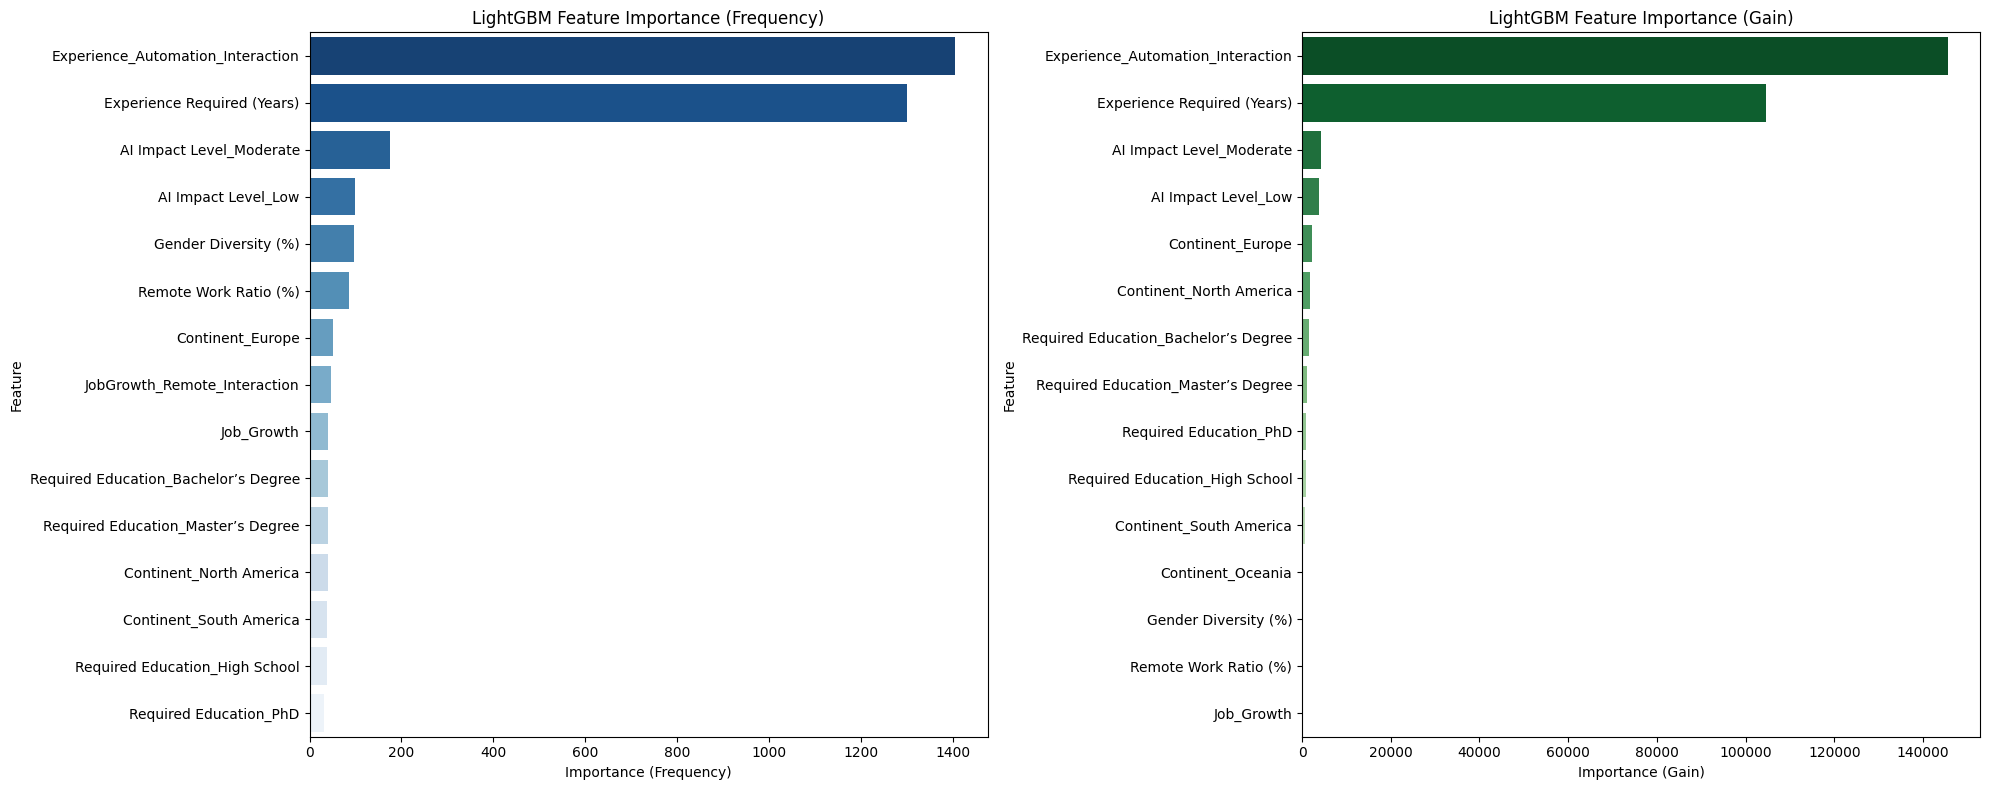

Generated 'lightgbm_feature_importance.png'.

7.2. SHAP Values (SHapley Additive exPlanations):
Calculating SHAP values. This might take a moment...

Generating SHAP Summary Plot...


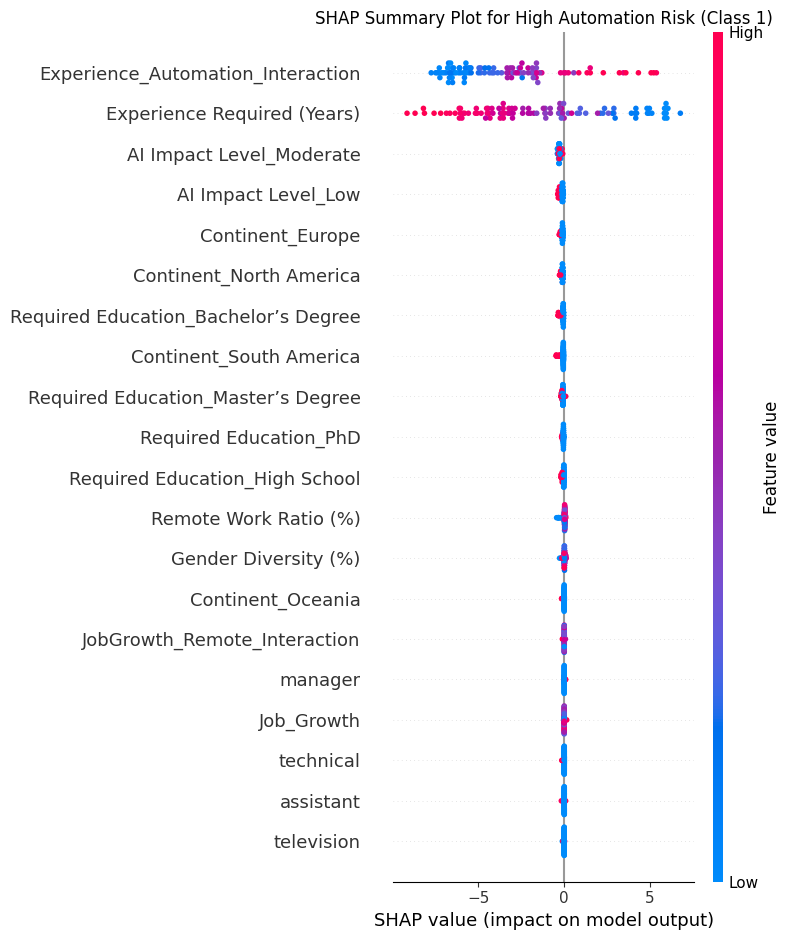

Generated 'lightgbm_shap_summary_plot.png'.

Generating SHAP Force Plot for a specific instance (first high-risk job in test set)...


Generated 'lightgbm_shap_force_plot_high_risk.html' for a high-risk job.

7.3. Partial Dependence Plots (PDP):
Generating PDPs for features: ['Experience Required (Years)', 'Job_Growth', 'Remote Work Ratio (%)']


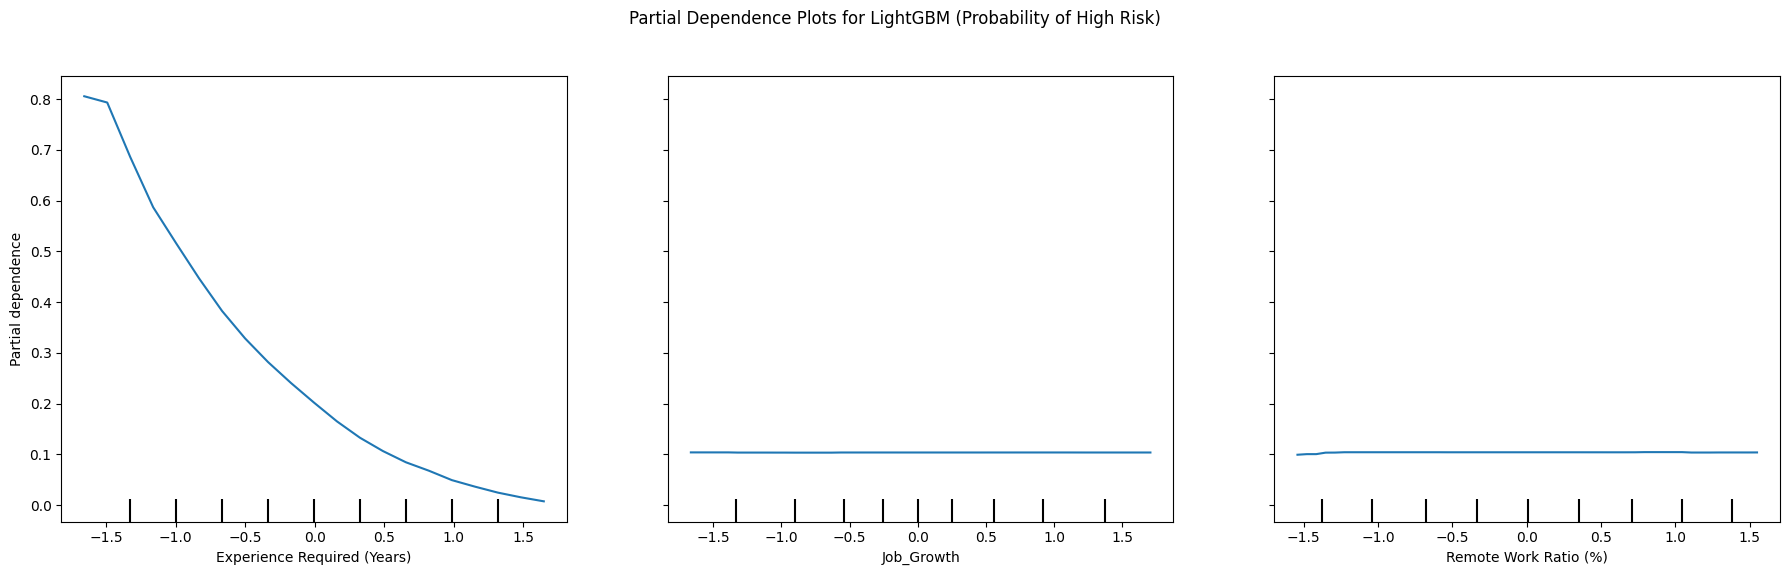

Generated 'lightgbm_partial_dependence_plots.png'.

--- LightGBM Interpretability Analysis Complete ---


In [ ]:
# --- 7. LightGBM Model Interpretability ---
print("\n--- 7. LightGBM Model Interpretability ---")

# Import necessary libraries for interpretability
import shap
from sklearn.inspection import PartialDependenceDisplay

# 7.1. Feature Importance (Gain and Frequency)
print("\n7.1. LightGBM Feature Importance (Gain and Frequency):")
lgbm_feature_importance_split = pd.Series(best_model_clf.feature_importances_, index=feature_names_clf)
lgbm_feature_importance_split = lgbm_feature_importance_split.nlargest(15)

lgbm_feature_importance_gain = pd.Series(best_model_clf.booster_.feature_importance(importance_type='gain'), index=feature_names_clf)
lgbm_feature_importance_gain = lgbm_feature_importance_gain.nlargest(15)

print("\nTop 15 Features by Importance (Frequency):")
print(lgbm_feature_importance_split)
print("\nTop 15 Features by Importance (Gain):")
print(lgbm_feature_importance_gain)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x=lgbm_feature_importance_split.values, y=lgbm_feature_importance_split.index, palette='Blues_r', ax=axes[0])
axes[0].set_title('LightGBM Feature Importance (Frequency)')
axes[0].set_xlabel('Importance (Frequency)')
axes[0].set_ylabel('Feature')

sns.barplot(x=lgbm_feature_importance_gain.values, y=lgbm_feature_importance_gain.index, palette='Greens_r', ax=axes[1])
axes[1].set_title('LightGBM Feature Importance (Gain)')
axes[1].set_xlabel('Importance (Gain)')
axes[1].set_ylabel('Feature')
plt.tight_layout()
plt.savefig('lightgbm_feature_importance.png')
plt.show()
print("Generated 'lightgbm_feature_importance.png'.")

# 7.2. SHAP Values (SHapley Additive exPlanations)
print("\n7.2. SHAP Values (SHapley Additive exPlanations):")
print("Calculating SHAP values. This might take a moment...")
explainer = shap.TreeExplainer(best_model_clf)

# Use a subset of the test data for SHAP to speed up computation
X_test_sample_shap = X_test_scaled_clf[np.random.choice(X_test_scaled_clf.shape[0],
                                                        min(100, X_test_scaled_clf.shape[0]),
                                                        replace=False)]
shap_values = explainer.shap_values(X_test_sample_shap)

# Handle binary vs multiclass formats
if isinstance(shap_values, list):
    # Binary or multiclass (list of arrays)
    shap_vals_to_plot = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    # Binary (new format: single array)
    shap_vals_to_plot = shap_values

# Ensure correct shape
if shap_vals_to_plot.ndim == 1:
    shap_vals_to_plot = shap_vals_to_plot.reshape(-1, 1)

# SHAP Summary Plot
print("\nGenerating SHAP Summary Plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_vals_to_plot, X_test_sample_shap, feature_names=feature_names_clf, show=False)
plt.title('SHAP Summary Plot for High Automation Risk (Class 1)')
plt.tight_layout()
plt.savefig('lightgbm_shap_summary_plot.png')
plt.show()
print("Generated 'lightgbm_shap_summary_plot.png'.")

# SHAP Force Plot for a specific instance
print("\nGenerating SHAP Force Plot for a specific instance (first high-risk job in test set)...")
high_risk_indices = np.where(y_test_clf == 1)[0]
if len(high_risk_indices) > 0:
    instance_idx = high_risk_indices[0]
    shap_values_instance = explainer.shap_values(X_test_scaled_clf[instance_idx,:].reshape(1, -1))
    if isinstance(shap_values_instance, list):
        shap_values_instance = shap_values_instance[1] if len(shap_values_instance) > 1 else shap_values_instance[0]

    instance_df = pd.DataFrame(X_test_scaled_clf[instance_idx,:].reshape(1, -1), columns=feature_names_clf)
    shap.initjs()
    force_plot_html = shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
                                      shap_values_instance,
                                      instance_df,
                                      show=False)
    with open('lightgbm_shap_force_plot_high_risk.html', 'w') as f:
        f.write(force_plot_html.html())
    print("Generated 'lightgbm_shap_force_plot_high_risk.html' for a high-risk job.")
else:
    print("No high-risk jobs found in the test set to generate a force plot.")

# 7.3. Partial Dependence Plots (PDP)
print("\n7.3. Partial Dependence Plots (PDP):")
pdp_features = []
if 'Automation Risk (%)' in feature_names_clf:
    pdp_features.append('Automation Risk (%)')
if 'Experience Required (Years)' in feature_names_clf:
    pdp_features.append('Experience Required (Years)')
if 'Job_Growth' in feature_names_clf:
    pdp_features.append('Job_Growth')
if 'Remote Work Ratio (%)' in feature_names_clf:
    pdp_features.append('Remote Work Ratio (%)')

if len(pdp_features) > 0:
    print(f"Generating PDPs for features: {pdp_features}")
    fig, ax = plt.subplots(figsize=(18, 6))
    PartialDependenceDisplay.from_estimator(best_model_clf, X_test_scaled_clf, features=pdp_features,
                                            feature_names=feature_names_clf,
                                            target=1, # Probability of the positive class
                                            grid_resolution=50, ax=ax)
    fig.suptitle('Partial Dependence Plots for LightGBM (Probability of High Risk)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('lightgbm_partial_dependence_plots.png')
    plt.show()
    print("Generated 'lightgbm_partial_dependence_plots.png'.")
else:
    print("No suitable features found for Partial Dependence Plots.")

print("\n--- LightGBM Interpretability Analysis Complete ---")
